# Model evaluation and hyperparameters tuning
In this notebook we will see how to build [pipelines](https://scikit-learn.org/stable/modules/compose.html#combining-estimators) of data transformers and estimators with Scikit-Learn and how to assess a model's performance.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
print("numpy version: %s"%np.__version__)
print("pandas version: %s"%pd.__version__)

numpy version: 1.23.1
pandas version: 1.4.3


## The Breast Cancer Wisconsin Data Set
In this notebook we will use the [Breast Cancer Wisconsin](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) data set from the UCI website. The data set contains 569 records of fine needle aspirate (FNA) of a breast mass with 30 features that describe the characteristics of the cell nuclei. The first two columns represent the unique sample ID and the diagnosis (M=malignant, B = benign).

In [4]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'
bcw_df = pd.read_csv(url, header=None)
bcw_df.shape

(569, 32)

In [5]:
bcw_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


We change the values of the diagnosis: from malignant (M) to 1, and from benign (B) to 0.

In [6]:
from sklearn.preprocessing import LabelEncoder

X = bcw_df.loc[:, 2:].values
y = bcw_df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)

### Data partition
We split the data set into a training set (80%) and a validation set (20%)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1)

## Scikit-Learn transformers, estimators and pipelines
Scikit-Learn provides several transformations such as the StandardScaler to standardize the input data and the PCA for dimensionality reduction. Classifiers and regressors are classes that implement algorithms for classification and regression tasks such as Logistic Regression or Support Vector Machines and are defined collectively as estimators. Transformer objects implement the fit() and transform() methods, estimator objects implement the fit() and prdict() methods. A pipeline with one or more transformers and a final estimator can be build to implement a task. In the example below we have set up a pipeline with two transformers and a final estimator.

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression())

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
test_acc = pipe_lr.score(X_test, y_test)
print(f'Test accuracy: {test_acc:.3f}')

Test accuracy: 0.956


## Model performance assessment
So far we have assessed a model performance, that is its generalization performance, using a subset of the original data set, the validation set. This is not a strategy that works in the real world because we may change the model hiperparameters to improve its performance and by training and testing using the same validation test it will make the validation test part of the training set and the model less likely to generalize well with data that have not been seen before. There are two common approaches to address this problem: the holdout method and the k-fold cross validation.  

### The holdout method
The holdout method consists of separating the original data set into three parts: the training set, the validation set and a test set. The validation set is used, as we have seen so far, to validate a model after its training. The test set is used after we have completed the tuning of the model and we want to test its generalization performance with that have never been used before.

### K-fold cross validation
The strategy used with k-folde cross validation is to split the data into k subsets, k-1 subsets are used for training one the remainng subset is used for validation. If we plan to tune our model's hyperparameters in 10 cycles of trainings and validations we can split the data into 10 subsets and use a different subset for validation at each cycle. Once we are done with the fine tuning we can train again the model with the best hyperparameters using the full data set. Scikit-Learn provides several functions for [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html): from [k-fold](https://scikit-learn.org/stable/modules/cross_validation.html#k-fold) discussed above, to [stratified cross validation](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold) in which the k subsets are created with the same percentage of data points from each of the classes in the data set.

In [9]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)

    print(f'Fold: {k + 1:02d}, '
          f'Class distr.: {np.bincount(y_train[train])}, '
          f'Acc.: {score:.3f}')
    
mean_acc = np.mean(scores)
std_acc = np.std(scores)
print(f'\nCV accuracy: {mean_acc:.3f} +/- {std_acc:.3f}')

Fold: 01, Class distr.: [256 153], Acc.: 0.935
Fold: 02, Class distr.: [256 153], Acc.: 0.935
Fold: 03, Class distr.: [256 153], Acc.: 0.957
Fold: 04, Class distr.: [256 153], Acc.: 0.957
Fold: 05, Class distr.: [256 153], Acc.: 0.935
Fold: 06, Class distr.: [257 153], Acc.: 0.956
Fold: 07, Class distr.: [257 153], Acc.: 0.978
Fold: 08, Class distr.: [257 153], Acc.: 0.933
Fold: 09, Class distr.: [257 153], Acc.: 0.956
Fold: 10, Class distr.: [257 153], Acc.: 0.956

CV accuracy: 0.950 +/- 0.014


## Fine-tuning
When we define a model we want to know whether it may overfit or underfit the data, in other words whether it has high variance or high bias. In the first case adding more data or reducing the model's complexity may improve the result while in the latter adding more data won't change the performance of the model while adding more features to the model might improve it. Scikit-Learn provides a function that outputs the training score and the validation score of an estimator (or model) for different numbers of training examples. The function [learning_curves()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html#sklearn.model_selection.learning_curve) takes as input the training set, the sizes of the data to use for the experiments, the number of folds (subsets) in which the data must be split in each experiment for cross-validation. In the following example. The training set is used as the input of the learning_curve() function. The train sizes is set from 0.1 (10% of the training set) to 20% up to 100% of the training set. For each experiment the validation is done with one subset out of 10 of the training set. The output of the function is used to plot the performance of the estimator at different size of the training data.     

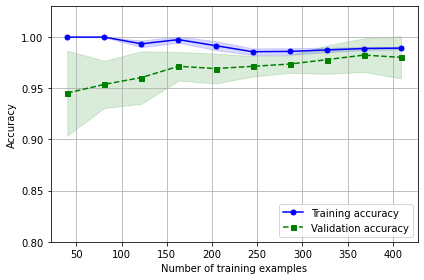

In [12]:
from sklearn.model_selection import learning_curve


pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2', max_iter=10000))

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                               X = X_train,
                                               y = y_train,
                                               train_sizes = np.linspace(0.1, 1.0, 10),
                                               cv = 10, # number of folds (subsets) to split the data set
                                               n_jobs = 1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()